# PennyLane: Variational classifier with Iris data

In this variational classifier we are going to use pennylane's [AmplitudeEmbedding](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AmplitudeEmbedding.html) template

In [37]:

# install
# !pip3 install pennylane
# !pip3 install pennylane-qiskit
# !pip3 install pylatexenc

# imports
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.templates import AmplitudeEmbedding
import matplotlib.pyplot as plt

from qiskit.visualization import plot_state_qsphere

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Create quantum device and load iris data and define some settings and trainings and validation datasets

In [38]:
##################################
# quantum device
dev = qml.device("default.qubit", wires=2)
#dev = qml.device("qiskit.aer", wires=2)

##################################
# load data
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2] # get X data
Y = data[:, -1] # get Y data
print("First X sample (original)  :", X[0])
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

##################################
# settings
num_qubits = 2
num_layers = 5
# batch size and optimizer
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0) # initial weights
var_init = (0.1 * np.random.randn(num_layers, num_qubits, 3), 0.0) # initial weights

##################################
# train and validation dataset
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)

index = np.random.permutation(range(num_data))

# feats_train = X[index[:num_train]] # use X
feats_train = X_pad[index[:num_train]] # use X_pad
Y_train = Y[index[:num_train]]

# feats_val = X[index[num_train:]] # use X
feats_val = X_pad[index[num_train:]] # use X_pad
Y_val = Y[index[num_train:]]

## We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]


## [Step 1] State preparation:
Here we are going to the AmplitudeEmbedding template

In [39]:
def statepreparation(f):
    AmplitudeEmbedding(features=f, wires=range(2), pad_with=0., normalize=True)



Test the current routine:

In [40]:
x_test_sample = np.array([0.4, 0.75, 0.3], dtype=np.float64)

print("x_test_sample", x_test_sample)

@qml.qnode(dev)
def test(features):
    statepreparation(features)
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

expvalues = test(x_test_sample)

@qml.qnode(dev)
def test_probs(features):
    statepreparation(features)
    return qml.probs(wires=[0, 1])

probs = test_probs(x_test_sample)

print("x               : ", x_test_sample)
print("expvalues       : ", expvalues)
print("probs           : ", probs)

if dev.short_name == "qiskit.aer":
  # only if device is qiskit
  display(dev._circuit.draw(output='mpl'))
else:
  print("amplitude vector: ", dev.state)
  print("amplitude vector (real): ", np.real(dev.state))
  print(test.draw())



x_test_sample [0.4  0.75 0.3 ]
x               :  [0.4  0.75 0.3 ]
expvalues       :  [ 0.77846154 -0.38461538]
probs           :  [0.19692308 0.69230769 0.11076923 0.        ]
amplitude vector:  [0.44376016+0.j 0.83205029+0.j 0.33282012+0.j 0.        +0.j]
amplitude vector (real):  [0.44376016 0.83205029 0.33282012 0.        ]
 0: ──╭QubitStateVector(M0)──┤ ⟨Z⟩ 
 1: ──╰QubitStateVector(M0)──┤ ⟨Z⟩ 
M0 =
[0.44376016+0.j 0.83205029+0.j 0.33282012+0.j 0.        +0.j]



Define `circuit`, variational classifier model, `square_loss`, `cost`, `accuracy` and `layer` function

In [41]:
def layer(weights):
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(weights, features):
    statepreparation(features)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(var, features):
    weights = var[0]
    bias = var[1]
    return circuit(weights, features) + bias

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss


In [42]:

# train the variational classifier
var = var_init

weightChanges = np.append([], var, axis=0)

iterations = 250

costs = np.zeros(iterations) # initialize costs array

# Do some iterations
for it in range(iterations):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    # gather informations for plotting
    weightChanges = np.append(weightChanges, var, axis=0)
    costs[it] = cost(var, X, Y) # overall costs

    print(
        "Iter: {:5d} | Overall Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, costs[it], acc_train, acc_val)
    )


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Iter:     1 | Overall Cost: 1.9605731 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Overall Cost: 1.9160534 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Overall Cost: 1.8534200 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     4 | Overall Cost: 1.7757566 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     5 | Overall Cost: 1.6668130 | Acc train: 0.5066667 | Acc validation: 0.5600000 
Iter:     6 | Overall Cost: 1.5706039 | Acc train: 0.5066667 | Acc validation: 0.5600000 
Iter:     7 | Overall Cost: 1.4606661 | Acc train: 0.5466667 | Acc validation: 0.6400000 
Iter:     8 | Overall Cost: 1.3256646 | Acc train: 0.6266667 | Acc validation: 0.7600000 
Iter:     9 | Overall Cost: 1.1928731 | Acc train: 0.7733333 | Acc validation: 0.8400000 
Iter:    10 | Overall Cost: 1.0614530 | Acc train: 0.7733333 | Acc validation: 0.6800000 
Iter:    11 | Overall Cost: 0.9813113 | Acc train: 0.6266667 | Acc validation: 0.6400000 
Iter:    1

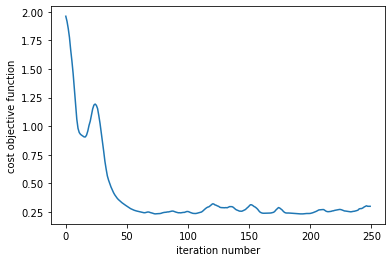

[[[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]]
---------------
[0] 0.03368951721806778, 0.06266755140779 ,0.05469885039154574
---
[0] -0.030784142001289684, 0.007341222633412296 ,-0.027666323932898047
---
[0] 0.013952190513585455, -0.005091297346480956 ,0.074009103354691
---
[0] -0.03233615748941204, 0.2400998060514719 ,0.28127453472185565
---
[0] 0.061912525957911725, -0.23287020857065288 ,0.11030053232581448
---
[0] 0.14051773077378207, -0.17122551148179266 ,0.03642797982580616
---
[0] -0.14142368417741763, 0.095331219785104 ,-0.043121105331275306
---
[0] -0.003607716240279841, -0.20218043776669933 ,0.08454991569914444
---
[0] -0.12116771262180202, 0.0009478491873971759 ,0.08603850117851802
---
[0] -0.01577955580404594, -0.06237734255309313 ,0.029725238712531493
---
[1] 0.03345551481423045, 0.06206238439369462 ,0.054434554276833254
---
[1] -0.030558745744278262, 0.007495450161811302 ,-0.027445354459618963
---
[

In [43]:
plt.figure()
plt.plot(range(iterations), costs)
plt.xlabel('iteration number')
plt.ylabel('cost objective function')
plt.show()

#print(weightChanges)
#print(len(weightChanges))
#print("---\n",weightChanges[0].shape)

#print("===\n",type(weightChanges[::2]))

matrix = [[[0 for x in range(3)] for y in range(2)] for u in range(num_layers)]
print(matrix)

leWeights=weightChanges[::2]

#print(leWeights)
print("---------------")

# num iterations
for i,o in enumerate(weightChanges[::2]): 
  # num layers
  for l in range(num_layers):
    # num qubits
    for j in range(num_qubits):
      print("[{}] {}, {} ,{}".format(i,o[l,j,0], o[l,j,1], o[l,j,2]))
      print("---")



In [44]:

# if device is "qiskit.aer"
if dev.short_name == "qiskit.aer":
  display(dev._circuit.draw(output="mpl"))
  # print(dev._circuit.draw())
else:
  # if device is "default.qubit"
  print(circuit.draw())

 0: ──╭QubitStateVector(M0)──Rot(-0.0412, -0.0451, -0.0276)──╭C──Rot(-0.0683, 0.653, 0.0495)──╭C──Rot(0.0374, -1.09, 0.136)─────╭C──Rot(-0.116, 0.545, -0.0202)──╭C──Rot(-0.0982, -0.307, 0.086)────╭C──┤ ⟨Z⟩ 
 1: ──╰QubitStateVector(M0)──Rot(-0.0202, 0.275, -0.00141)───╰X──Rot(-0.107, 1.1, 0.0512)─────╰X──Rot(0.0567, 0.0239, -0.0463)──╰X──Rot(-0.0389, -0.12, 0.051)───╰X──Rot(-0.0158, -0.0624, 0.0297)──╰X──┤     
M0 =
[0.86824314+0.j 0.49613894+0.j 0.        +0.j 0.        +0.j]



Final Plot of the continuous output of the variational classifier for the first two dimensions of the Iris data set:

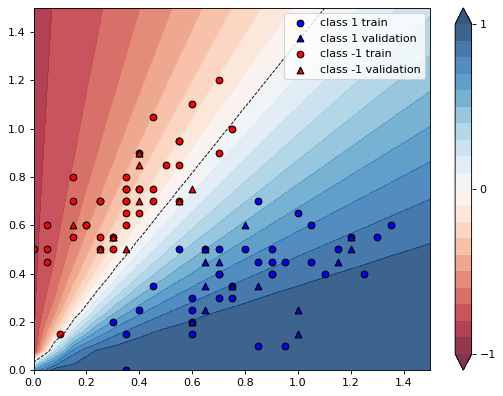

In [46]:
plt.figure(figsize=(8, 6), dpi=80)
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
# padding = 0.3 * np.ones((len(X_grid), 1))
padding = 1e-12 * np.ones((len(X_grid), 1))

X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input

normalization = np.sqrt(np.sum(X_grid ** 2, -1))

X_grid = (X_grid.T / normalization).T  # normalize each input

predictions_grid = [variational_classifier(var, f) for f in X_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

Relevant links & papers:
- https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
- [Circuit-centric quantum classifiers](https://arxiv.org/pdf/1804.00633.pdf)
- [Transformation of quantum states using uniformly controlled rotations](https://arxiv.org/abs/quant-ph/0407010)
- https://pennylane.ai/qml/demos/tutorial_general_parshift.html

# Todo: paper to onedrive 